In [1]:
import os
import pandas as pd
from shutil import copy
from importlib import reload
import classif_output_structs as cos
cos = reload(cos)

import warnings
warnings.filterwarnings('ignore')

In [13]:
def combo_dupes(collection, dupes_to_count:list, group_dupes=False):

    nested_best_epochs = [series.best_epochs for series in collection.collection]
    all_best_epochs = [j for i in nested_best_epochs for j in i]
    combo = cos.ComboEpoch( all_best_epochs )
    
    if group_dupes:
        dupes_to_count = [dupes_to_count]
    dupe_dict = {}
    for dupe_count in dupes_to_count:
        df = combo.pairwise_df(skip_correct=True,
                         skip_empties=True,
                         keep_dupes=dupe_count)
        img_dict = df.images.to_dict()
        if img_dict: # if it's not empty
            if group_dupes:
                dupe_count = '-'.join(['{:02}'.format(x) for x in dupe_count])
            else: dupe_count = '{:02}'.format(dupe_count)
            dupe_dict[dupe_count] = img_dict
    
    return dupe_dict


def transcribe_dupes(dupe_dict, name, root='naughty_export',
                     target_dir_format='{} ... {}', dry_run=False):

    for dupe_num in dupe_dict:
        print();print(80*'=')
        print(name, 'dupes:', dupe_num,'\n')
        for ikey,okey in dupe_dict[dupe_num]:
            dupe_dir = '{}_dupes'.format(dupe_num)
            target_dir = target_dir_format.format(ikey,okey) # may need to be edited for groupping reasons
            target_dir = os.path.join(root,name,dupe_dir,target_dir)
            if not dry_run: os.makedirs(target_dir, exist_ok=True)
            ipaths = dupe_dict[dupe_num][(ikey,okey)]
            for src in ipaths:
                orig_class = src.split('/')[-2]
                orig_fname = src.split('/')[-1]
                if orig_class == ikey: target_dir_mod = target_dir
                else: 
                    target_dir_mod = target_dir.replace(' ...','@{} ...'.format(orig_class))
                
                if dry_run: 
                    print(src, '\n\tEXPORT-TO', target_dir_mod)
                else: 
                    os.makedirs(target_dir_mod, exist_ok=True)
                    if '@' in target_dir_mod: print(os.path.join(target_dir_mod,orig_fname))
                    copy(src, os.path.join(target_dir_mod,orig_fname))


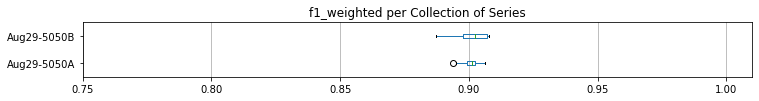

In [4]:
    
coll = cos.Collection(['Aug29-5050A',
                       'Aug29-5050B'],
                      best_epochs_only=True, ignore_series_metadata=True)

ax = coll.boxplot('f1_weighted', start=0.75)


In [5]:
# collect all images from dupes results
images_A=coll.collection[0].best_best_epoch.true_images
images_B=coll.collection[1].best_best_epoch.true_images

# assert images sets A and B are unique
assert(len(set(images_A) & set(images_B)) == 0 )

# assert that all dupe images truely do exist
assert all([os.path.isfile(img) for img in images_A+images_B])

images_dupes = [img.replace('from-sosiknas/Aug29_fullset/','./') for img in images_A+images_B]

#images_dupes = sorted(images_dupes)
# optionally, save the list
#with open('img_verif/Aug29_fullset.dupes.list', 'w') as f:
#    for img in input:
#        f.write(img+'\n')

In [98]:

# assert all images from hpc list is present locally
with open('img_verif/Aug29_fullset.hpc.list') as f:
    images_hpc = [img.strip() for img in f.readlines()]
    images_hpc = [img for img in images_hpc if len(img.split('/'))==3]
    images_hpc = [img for img in images_hpc if img.endswith('.png')]
assert all([os.path.isfile(img.replace('./','from-sosiknas/Aug29_fullset/')) for img in images_hpc])

# list 
print('images_missing_from_dupes:',len(images_dupes)-len(images_hpc))
print('perhaps from classes being ignored!')
images_missing_from_dupes = sorted(list(set(images_hpc) - set(images_dupes)))
images_missing_from_dupes[::1000]

images_missing_from_dupes: -7837
perhaps from classes being ignored!


['./Alexandrium_catenella_chain/D20120411T102928_IFCB010_00003.png',
 './Amylax/D20120418T023111_IFCB010_04307.png',
 './Heterocapsa_triquetra_singlet_section/D20140420T000903_IFCB012_01633.png',
 './Heterocapsa_triquetra_singlet_section/D20140420T182308_IFCB012_00935.png',
 './Karenia_brevis_stress/D20180913T061852_IFCB124_02208.png',
 './Karenia_brevis_stress/D20180913T120800_IFCB124_03808.png',
 './Karenia_brevis_stress/D20180914T000935_IFCB124_05978.png',
 './Lingulodinium_polyedrum/D20160829T040630_IFCB110_00412.png']

In [7]:

cd = combo_dupes(coll,[10,9], group_dupes=True)
cd.keys()
#cd['10-09'][('Amphidinium','Dinophyceae')]


['from-sosiknas/Aug29_fullset/Amphidinium/IFCB5_2017_188_000039_02100.png',
 'from-sosiknas/Aug29_fullset/Amphidinium/IFCB5_2013_167_152816_06577.png']

In [14]:

transcribe_dupes(cd, name='Aug29_dupes',dry_run=False)

#from-sosiknas/Aug29_fullset/mix_elongated/IFCB1_2016_135_210919_04990.png 
#	EXPORT-TO naughty_export/Aug29_dataset/10-09-08_dupes/Bacillariophyceae@mix_elongated ... Dinobryon


Aug29_dupes dupes: 10-09 



# Applying corrected Dupes

In [54]:
# "./INPUT_CLASS ... OUTPUT_CLASS/D20181120T205236_IFCB010_00143.png"
# "./INPUT_CLASS ... OUTPUT_CLASS/Confounded/IFCB1_2006_285_182309_01171.png"
# "./Dinophyceae ... detritus/move_to_OTHER_CLASS/IFCB1_2014_156_182931_02915.png"
# "./GROUP_CLASS@SRC_CLASS ... OUTPUT_CLASS/move_to_OTHER_CLASS/IFCB1_2014_156_182931_02915.png"

def dupelist_check(dupelist, existing_classes = coll.collection[0].classes ):
    brand_new_classes = []
    ibrand_new_classes = []
    delete_dirs = []
    anomalies = []
    with open(dupelist) as f:
        for line in f:
            if 'Thumbs.db' in line or '.DS_Store' in line:
                continue  # skip garbage
            line = line.strip().split('/')
            assert line[0] == '.'
            try:
                # "Dinophyceae ... detritus" 
                inclass,outclass = line[1].split(' ... ')
                inclass = inclass.split('@')[-1] # NEW! handles grouped classes
                
                if line[2].endswith('.png'):
                    pass
                elif line[2].startswith('move_to_'):
                    newclass = line[2].replace('move_to_','')
                    if newclass not in existing_classes and\
                       newclass not in brand_new_classes:
                        brand_new_classes.append(newclass)
                    if newclass.lower() not in [x.lower() for x in existing_classes] and\
                       newclass not in ibrand_new_classes:
                        ibrand_new_classes.append(newclass)
                else: # mark line for deletion
                    #delete_me = '/'.join(line[:3])
                    delete_me = line[2]
                    if delete_me not in delete_dirs: delete_dirs.append(delete_me)
            except: 
                anomalies.append('/'.join(line))            
    
    print('Anomalies:',anomalies)
    print('\nBrand New Classes')
    [print('   ',x) for x in sorted(brand_new_classes)]
    if brand_new_classes != ibrand_new_classes:
            print('Note: existing classz but with move_to CASE errors')
            case_errors = [x for x in set(brand_new_classes)-set(ibrand_new_classes)]
            print(case_errors)
    print('\n Delete dDirs')
    [print('   ',x) for x in delete_dirs]
    
def dupelist_collate(dupelist):
    move_tos = []
    delete_mes = []
    with open(dupelist) as f:
        for line in f:
            if 'Thumbs.db' in line or '.DS_Store' in line:
                continue  # skip garbage

            # "./INPUT_CLASS ... OUTPUT_CLASS/D20181120T205236_IFCB010_00143.png"
            # "./INPUT_CLASS ... OUTPUT_CLASS/Confounded/IFCB1_2006_285_182309_01171.png"
            # "./Dinophyceae ... detritus/move_to_OTHER_CLASS/IFCB1_2014_156_182931_02915.png"
            # "./GROUP_CLASS@SRC_CLASS ... OUTPUT_CLASS/move_to_OTHER_CLASS/IFCB1_2014_156_182931_02915.png"

            line = line.strip().split('/')
            try:
                # "Dinophyceae ... detritus" 
                inclass,outclass = line[1].split(' ... ')   
                inclass = inclass.split('@')[-1] # NEW! handles grouped classes

                fname = line[-1]
                if line[2].endswith('.png'):
                    move_tos.append( (inclass,outclass,fname) )
                elif line[2].startswith('move_to_'):
                    newclass = line[2].replace('move_to_','')
                    move_tos.append( (inclass,newclass,fname) )
                else:
                    #mark line3 for deletion
                    delete_mes.append( (inclass,fname) )
            except Exception as e: 
                print(e)
    return move_tos,delete_mes


def dupelist_verify(tups, target_dataset):
    for tup in tups:
        orig_class,fname = tup[0],tup[-1]
        orig_path = os.path.join(target_dataset,orig_class,fname)
        if not os.path.isfile(orig_path): 
            print('    MISSING:',orig_path) 


def dupelist_move(tups,target_dataset):
    for tup in tups:
        try:
            orig_class,move_class,fname = tup
        except ValueError:
            orig_class,fname = tup
            move_class = 'DELETES'
        orig_path = os.path.join(target_dataset,orig_class,fname)
        move_path = os.path.join(target_dataset,move_class,fname)
        move_dir  = os.path.join(target_dataset,move_class)
        if not os.path.isdir(move_dir):
            os.mkdir(move_dir)
        os.rename(orig_path,move_path)
    print('    {} DONE'.format( 'Move-to' if len(tups[0])==3 else 'Deletes'))


dupelist = 'naughty_export/Aug29_dupelist.txt' # made using: find . -type f > dupelist.txt
target = 'data/Jan_fullset'

dupelist_check(dupelist)
move_tos,delete_mes = dupelist_collate(dupelist)

print('\nMove-to:',len(move_tos),'Deletes:',len(delete_mes))
print('\nMissing MOVE-FROMs...')
dupelist_verify(move_tos,target)
print('Missing DELETE-MEs...')
dupelist_verify(delete_mes,target)

# Uncomment to activate #
##dupelist_move(move_tos,target_dataset=target)
##dupelist_move(delete_mes,target_dataset=target)


Anomalies: []

Brand New Classes
    Ceratium_furca
    Ceratium_fusus
    Ceratium_lineatum
    Podolampas
    Pyramimonas_morphotype3
    Warnowia
    other

 Delete dDirs
    Confounded
    Somedoubt
    somedoubt
    Someodoubt

Move-to: 6803 Deletes: 512

Missing MOVE-TOs...
    MISSING: data/Aug29_fullset/Pseudo-nitzschia/D20170530T201609_IFCB010_00647.png
    MISSING: data/Aug29_fullset/Pseudo-nitzschia/IFCB5_2016_232_171902_06611.png
    MISSING: data/Aug29_fullset/Phaeocystis/IFCB1_2011_285_195152_00268.png
    MISSING: data/Aug29_fullset/Phaeocystis/IFCB5_2011_030_165307_01103.png
    MISSING: data/Aug29_fullset/Phaeocystis/IFCB1_2011_285_184213_04783.png
    MISSING: data/Aug29_fullset/Phaeocystis/D20181120T205236_IFCB010_00143.png
    MISSING: data/Aug29_fullset/Amphidinium/IFCB5_2015_008_023005_00807.png
    MISSING: data/Aug29_fullset/Amphidinium/IFCB1_2008_085_024052_00384.png
    MISSING: data/Aug29_fullset/Chaetoceros/IFCB5_2017_036_125809_01916.png
    MISSING: data/A

    MISSING: data/Aug29_fullset/mix_elongated/D20130824T223629_IFCB010_01201.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2011_326_170712_05006.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2008_218_181829_03125.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2006_205_001923_02459.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2015_232_180551_01933.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2012_029_074749_02583.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2008_237_204407_02588.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2011_039_034322_02683.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2016_018_040704_05455.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2010_345_124713_00514.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2008_144_154542_01789.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2017_355_182816_08796.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2009_006_

    MISSING: data/Aug29_fullset/Chaetoceros/IFCB1_2009_230_120831_01182.png
    MISSING: data/Aug29_fullset/Chaetoceros/IFCB1_2008_194_002638_03306.png
    MISSING: data/Aug29_fullset/Chaetoceros/IFCB1_2012_266_024224_03863.png
    MISSING: data/Aug29_fullset/Chaetoceros/IFCB1_2009_224_165556_03361.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2017_103_164054_03658.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2009_133_220801_00307.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2011_255_210152_01451.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2009_132_190907_00169.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2011_187_170411_03824.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2011_167_022908_02494.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB1_2006_171_001337_01097.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2015_025_025114_04051.png
    MISSING: data/Aug29_fullset/mix_elongated/IFCB5_2017_089_184920_0007

    MISSING: data/Aug29_fullset/cryptophyta/IFCB1_2007_318_004837_06257.png
    MISSING: data/Aug29_fullset/cryptophyta/IFCB1_2007_318_000513_01808.png
    MISSING: data/Aug29_fullset/cryptophyta/IFCB1_2006_171_005706_00305.png
    MISSING: data/Aug29_fullset/Corymbellus/IFCB1_2006_285_173940_00357.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB1_2015_208_201119_00123.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB1_2009_172_005054_04091.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB1_2008_236_005047_00702.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB1_2009_172_000431_02162.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB1_2008_235_205819_00308.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB1_2009_172_005054_00177.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB5_2011_208_191537_00340.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB1_2007_168_001625_00703.png
    MISSING: data/Aug29_fullset/Leptocylindrus/IFCB1_2009_215_00

    MISSING: data/Aug29_fullset/Pyramimonas/IFCB5_2016_301_185921_08285.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB1_2012_177_204001_01466.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB5_2016_237_174832_05033.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB5_2016_237_172521_04062.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB5_2016_301_183608_09375.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB1_2008_200_001337_00627.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB1_2008_218_010148_00014.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB1_2013_302_170210_00184.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB1_2008_233_204452_01824.png
    MISSING: data/Aug29_fullset/Pyramimonas/D20150521T184354_IFCB101_00052.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB5_2016_237_174832_02581.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB5_2016_237_174832_02713.png
    MISSING: data/Aug29_fullset/Pyramimonas/IFCB1_2008_218_184206_02958.png
    MISSI

    MISSING: data/Aug29_fullset/Heterocapsa_triquetra/IFCB1_2012_151_154317_01502.png
    MISSING: data/Aug29_fullset/Heterocapsa_triquetra/IFCB1_2006_158_185109_01835.png
    MISSING: data/Aug29_fullset/Heterocapsa_triquetra/IFCB1_2012_151_160629_01730.png
    MISSING: data/Aug29_fullset/Heterocapsa_triquetra/IFCB1_2009_172_002825_04636.png
    MISSING: data/Aug29_fullset/Heterocapsa_triquetra/IFCB1_2006_158_182925_00277.png
    MISSING: data/Aug29_fullset/Heterocapsa_triquetra/D20150526T012137_IFCB101_00686.png
    MISSING: data/Aug29_fullset/Bacillariophyceae/IFCB1_2009_288_130947_02817.png
    MISSING: data/Aug29_fullset/Bacillariophyceae/IFCB1_2009_294_145539_02400.png
    MISSING: data/Aug29_fullset/Bacillariophyceae/IFCB5_2017_355_182816_04475.png
    MISSING: data/Aug29_fullset/flagellate/IFCB5_2012_198_234009_04761.png
    MISSING: data/Aug29_fullset/Guinardia_delicatula_external_parasite/IFCB5_2011_173_020643_01172.png
    MISSING: data/Aug29_fullset/Guinardia_delicatula_exte

    MISSING: data/Aug29_fullset/Ceratium/D20130901T070350_IFCB010_00517.png
    MISSING: data/Aug29_fullset/Ceratium/D20150521T103804_IFCB101_00227.png
    MISSING: data/Aug29_fullset/Ceratium/D20150521T062824_IFCB101_00361.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB5_2016_195_034827_06084.png
    MISSING: data/Aug29_fullset/Ceratium/D20130831T100913_IFCB010_00349.png
    MISSING: data/Aug29_fullset/Ceratium/D20151021T031344_IFCB101_00108.png
    MISSING: data/Aug29_fullset/Ceratium/D20130831T204441_IFCB010_00142.png
    MISSING: data/Aug29_fullset/Ceratium/D20131108T091727_IFCB101_00093.png
    MISSING: data/Aug29_fullset/Ceratium/D20130901T103022_IFCB010_02468.png
    MISSING: data/Aug29_fullset/Ceratium/D20130904T000728_IFCB010_00179.png
    MISSING: data/Aug29_fullset/Ceratium/D20130825T072324_IFCB014_00123.png
    MISSING: data/Aug29_fullset/Ceratium/D20150520T062529_IFCB101_00209.png
    MISSING: data/Aug29_fullset/Ceratium/D20131108T192919_IFCB101_00381.png
    MISSING: da

    MISSING: data/Aug29_fullset/Ceratium/IFCB5_2016_167_192008_04842.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2009_195_214914_01044.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB5_2017_338_175925_04520.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2009_345_182011_03637.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2009_288_202112_05993.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2008_240_160700_02239.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2009_196_160017_01111.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2009_196_194657_04495.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2009_030_194532_00313.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2009_196_192313_05307.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB1_2008_236_000420_01212.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB5_2011_195_164440_04058.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB5_2011_188_163602_03952.png
    MISSING: data/Aug29_fullset/Ceratium/IFCB5_2017

    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB5_2014_259_113906_03993.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2009_206_002109_00906.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2009_206_005118_02641.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2011_218_200940_00494.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB5_2012_192_165320_03908.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2009_206_004500_01185.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2009_189_001612_01019.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2009_189_001612_00778.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2009_189_001612_01724.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2008_200_003651_03770.png
    MISSING: data/Aug29_fullset/Dactyliosolen_fragilissimus/IFCB1_2007_158_14033